In [97]:
import random
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sstats
from tqdm.auto import tqdm

In [98]:
def read_data(verbose = False):
    
    with open('ImageRawReduced.txt') as f:
        image = np.array([ list( map ( float, str.split( line.strip() ) ) ) for line in f])
        
    with open('ClassificationRules.txt') as f:
        rules = np.array([ list( map ( float, str.split( line.strip() ) ) ) for line in f])
    
    with open('ImageExpertReduced.txt') as f:
        expert = np.array([list( map ( float, str.split( line.strip() ) ) ) for line in f])
        expert = expert.ravel()
    
    if verbose:
        print('ImageRaw:\n', image)
        print('Rules:\n', rules)
        print('Expert:\n', expert)
    
    return image, rules, expert


In [99]:
def plot(arg, data, probabilities):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle(arg)
    
    ax1.set_title('Probabilities')
    ax1.plot(probabilities)
    
    ax2.set_title('Costs')
    ax2.plot(data[0], label="Top scores")
    ax2.plot(data[2], label="Mean scores")
    ax2.plot(data[1], label="Worst scores")
    ax2.legend(loc='lower right')
    
    plt.show()

In [123]:
def classified_points(x):
    
    #check which rules we take
    x = np.array(x)
    chosen_rules = rules[x == 1] #rules on which index, x[i] = 1
    
    # classify the points by majority of 'votes' for a point by chosen rules
    predictions = sstats.mode(chosen_rules, axis = 0)[0]
    predictions = predictions.ravel() #classified points
    
    # return number of correct classified points
    return sum(predictions == expert)
    
def binary_random(p):
    # creating a gen
    if random.uniform(0,1) < p:
        return 1
    return 0

def random_population(p,N,d):
    ans = [] # population
    for i in range(N):
        #adding random individuals
        ans.append([binary_random(p[j]) for j in range(d)])
    return ans

def evaluate_pop(pop,F):
    best_i = pop[-1]
    best_score = F(pop[-1])
    worst_score = F(pop[-1])
    mean_score = F(pop[-1])
    
    for i in range(len(pop) - 1):
        cost = F(pop[i])
        if cost > best_score:
            best_i = pop[i]
            best_score = cost
        if cost < worst_score:
            worst_score = cost
        mean_score += cost
        
    return best_i,best_score,worst_score,mean_score/len(pop)
    
def PBIL(d,F,N,T1,T2,T3,it):
    prob = [0.5 for i in range(d)]
    pop = random_population(prob,N,d)
    
    #data colected every iteration
    data = np.zeros((3,it)) # matrix of [b_score, m_score, w_score]
    probabilities = []
    b_indiv = []

    for i in tqdm(range(it)):
        
        scores = evaluate_pop(pop,F)
        x = scores[0] # best individual
        probabilities.append(prob.copy())
        b_indiv.append(x.copy())
        
        #save data from evaluating population
        for j in range(len(scores) - 1):
            data[j][i] = scores[j + 1]
            
        for k in range(d):
            #learning
            prob[k] = prob[k] * (1 - T1) + x[k] * T1
        for k in range(d):
            #mutating
            if random.uniform(0,1) < T2:
                prob[k] = prob[k] * (1 - T3) + binary_random(0.5) * T3
        pop = random_population(prob,N,d)
        
    return data, probabilities, b_indiv
        

In [124]:
image, rules, expert = read_data(verbose = True)

ImageRaw:
 [[26. 29. 33. ... 34. 31. 41.]
 [16. 23. 24. ... 22. 26. 30.]
 [75. 68. 86. ... 20. 25. 23.]]
Rules:
 [[1. 1. 1. ... 1. 1. 3.]
 [1. 1. 1. ... 3. 3. 3.]
 [1. 1. 1. ... 2. 2. 2.]
 ...
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]]
Expert:
 [1. 1. 1. ... 3. 3. 3.]


In [135]:
a = [266, classified_points, 100, 0.015, 0.025, 0.01, 500, "classified_points"]
data, probabilities, b_indiv = PBIL(*a[:-1])

At most 9202.0 correct classified points in 474 iteration which is 98.4171% accuracy
Best rules to take:
 [  1   2   5   6   7   8  13  15  16  17  18  19  24  27  30  32  35  37
  38  40  41  42  43  45  48  49  50  51  58  59  69  71  72  73  74  76
  77  79  80  81  86  87  90  91  94  95  99 102 103 104 105 106 107 109
 111 114 116 119 128 129 130 132 133 135 136 137 138 139 140 141 142 143
 144 145 146 148 149 151 152 154 155 156 158 159 160 161 163 164 165 166
 168 169 173 174 175 176 178 180 181 184 186 187 188 192 197 204 205 207
 209 210 215 224 225 227 232 237 238 247 248 249 253 262]


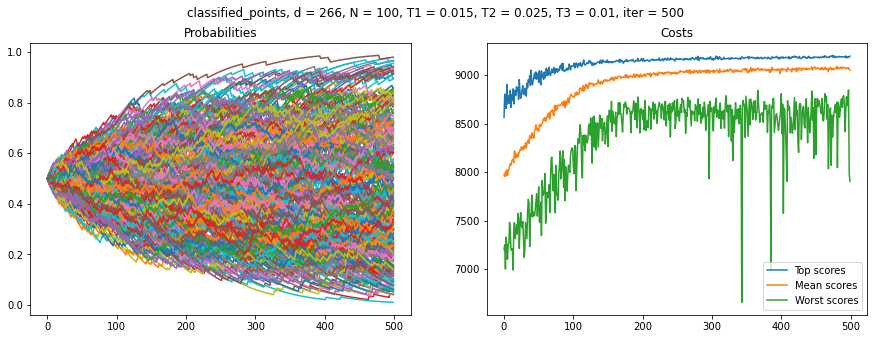

In [140]:
d,func,N,T1,T2,T3,it,name = a
arg = f'{name}, d = {d}, N = {N}, T1 = {T1}, T2 = {T2}, T3 = {T3}, iter = {it}'

scores = np.array(data[0])
best_s = np.argmax(scores)

print(f'At most {scores[best_s]} correct classified points \
in {best_s} iteration which is {scores[best_s] / len(expert) * 100.0:.4f}% accuracy')

best_rules = np.array(b_indiv[best_s])
b_r = np.arange(266)[best_rules == 1]
print(f'Best rules to take:\n {b_r}')

plot(arg, data, probabilities)